<h3> In this Series, I want to show the source code for a full pipeline to train and make predictions. I use MelSpectrogram to generate vector embedding for audio with TorchAudio Lib </h3>

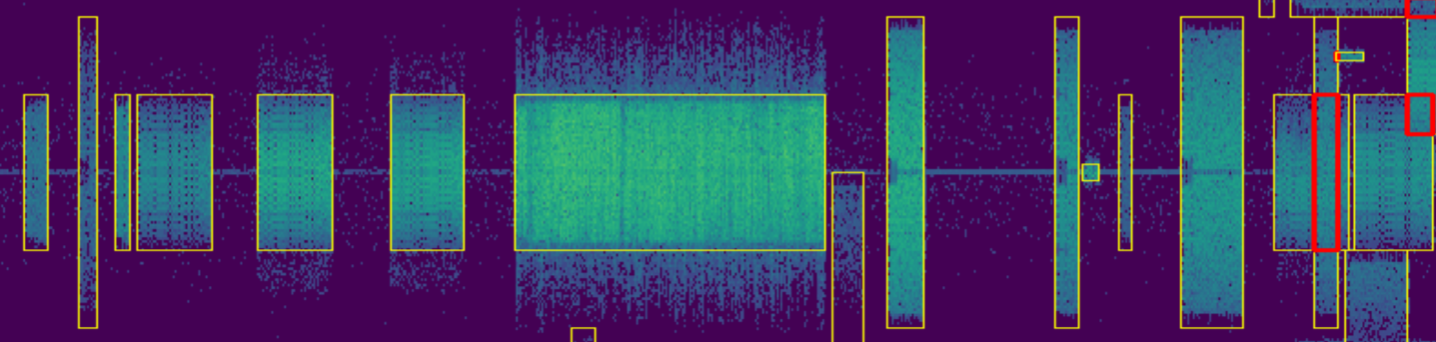

**Note**

* Stage 1 - Training: https://www.kaggle.com/code/bibanh/full-pipeline-melspectrogram-stage-1-training

* Stage 2 - Inference: https://www.kaggle.com/code/bibanh/full-pipeline-melspectrogram-stage-2-inference 

# 1. Imports

## 1.1 Import some necessary libraries

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import torchvision


In [35]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import os

import math, random

## 1.2 Set random seed

In [36]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 0
seed_everything(seed)

## 1.3 Some config parameters

In [37]:
class CFG:
    isOneHot = False
    rate = 32000
    num_classes = 264

## 1.4 Load a sample to get size and rate (32k Hz)

In [38]:
sig, sr = torchaudio.load('/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg')
print('shape:',sig.shape)
print('rate:', sr)

shape: torch.Size([1, 1459513])
rate: 32000


# 2. MelSpectrogram for Vector Embedding

In [39]:
class AudioUtil():
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig, sig])

    return ((resig, sr))

  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

# 3. Lable Encoder

In [40]:
meta_df = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')
print('data shape:',meta_df.shape)
meta_df.head()

data shape: (16941, 12)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [41]:
# Assuming 'primary_label' is the name of the column
# Get the unique categories in the 'primary_label' column
unique_categories = meta_df['primary_label'].unique()

# Take the first 10 unique categories
first_10_categories = unique_categories[:10]

# Create a new DataFrame with only the rows where 'primary_label' is in the first_10_categories
meta_df = meta_df[meta_df['primary_label'].isin(first_10_categories)]
print(meta_df.shape)

(473, 12)


In [42]:
print('Number of classes and number samples in each class:',meta_df.primary_label.value_counts().reset_index().shape)
print('Number of classes with more than 1 sample:',meta_df.primary_label.value_counts().reset_index()\
                                                              .query('primary_label > 1').shape)

Number of classes and number samples in each class: (10, 2)
Number of classes with more than 1 sample: (10, 2)


In [43]:
if CFG.isOneHot:
    label = OneHotEncoder(sparse=False)\
                                    .fit_transform(meta_df['primary_label'].to_numpy().reshape(-1,1))
    meta_df['label'] = pd.DataFrame(label).apply(lambda x: list(x), axis = 1)
else:
    meta_df['label'] = LabelEncoder().fit_transform(meta_df['primary_label'])
meta_df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,0
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,0


# 4. Define DataLoader and Fold Training/Validation

## 4.1 5-Fold Split

In [44]:
def cv_split(Xtrain, ytrain, n_folds, seed):
    kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)
    for num, (train_index, val_index) in enumerate(kfold.split(Xtrain, ytrain)):
        Xtrain.loc[val_index, 'fold'] = int(num)
    Xtrain['fold'] = Xtrain['fold'].astype(int)
    return Xtrain

meta_df = cv_split(meta_df,meta_df['primary_label'], 5, 42)
meta_df.head(6)




,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label,fold
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,0,3
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,0,3
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg,0,0
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg,0,4
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg,0,1
5,abethr1,['rbsrob1'],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/379322,abethr1/XC379322.ogg,0,2


## 4.2 DataLoader 

In [45]:
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path ='/kaggle/input/birdclef-2023/train_audio/', mode='train'):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 8000
    self.sr = 32000
    self.channel = 3
    self.shift_pct = 0.4
    self.mode = mode
    
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  def __getitem__(self, idx):
    audio_file = self.data_path + self.df.loc[idx, 'filename']
    # Get the Class ID
    class_id = np.array(self.df.loc[idx, 'label'])
    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)
    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    if self.mode == 'train':
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        return aug_sgram, class_id
    else:
        shift_aud = dur_aud
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        return sgram, class_id
        

In [46]:
train_ds = SoundDS(meta_df[meta_df.fold != 0].reset_index(), mode='train')
test_ds = SoundDS(meta_df[meta_df.fold == 0].reset_index(), mode='test')
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=True)

print('train samples ', meta_df[meta_df.fold != 0].shape)
print('test samples ', meta_df[meta_df.fold == 0].shape)

train samples  (378, 14)
test samples  (95, 14)


## 4.3 Test DataLoader

In [47]:
a,b = next(iter(train_dl))
print(a.shape)
print(b.shape)

torch.Size([16, 3, 64, 501])
torch.Size([16])


# 5. Import Backbone Pretrained Model

In [48]:
model = torchvision.models.resnet34(pretrained=True)


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, CFG.num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = model.to(device)
next(myModel.parameters()).device

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device(type='cuda', index=0)

# 6. Start Training 

In [49]:
# ----------------------------
# Training Loop
# ----------------------------

def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  best_acc = -1
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        if (i + 1) % 1 == 0:    # print every 10 mini-batches
           print('Epoch [{}/{}], Step [{}/{}], Loss : {:.4f}'
            .format(epoch + 1, num_epochs, i + 1, len(train_dl), running_loss/(i + 1)))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')

    if (best_acc < acc):
        best_acc = acc
        print("Saving best model!")
        torch.save(model.state_dict(), f'BirdSound_MobileNetV2_fold0_epoch{epoch}.pth')

  print('Finished Training')
  
num_epochs = 15   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

Epoch [1/15], Step [1/24], Loss : 5.6219
Epoch [1/15], Step [2/24], Loss : 5.3636
Epoch [1/15], Step [3/24], Loss : 5.0221
Epoch [1/15], Step [4/24], Loss : 4.9101
Epoch [1/15], Step [5/24], Loss : 4.5313
Epoch [1/15], Step [6/24], Loss : 4.2813
Epoch [1/15], Step [7/24], Loss : 4.0626
Epoch [1/15], Step [8/24], Loss : 4.1152
Epoch [1/15], Step [9/24], Loss : 3.8533
Epoch [1/15], Step [10/24], Loss : 3.7177
Epoch [1/15], Step [11/24], Loss : 3.5946
Epoch [1/15], Step [12/24], Loss : 3.4083
Epoch [1/15], Step [13/24], Loss : 3.4044
Epoch [1/15], Step [14/24], Loss : 3.3890
Epoch [1/15], Step [15/24], Loss : 3.2875
Epoch [1/15], Step [16/24], Loss : 3.1850
Epoch [1/15], Step [17/24], Loss : 3.1074
Epoch [1/15], Step [18/24], Loss : 3.0479
Epoch [1/15], Step [19/24], Loss : 2.9908
Epoch [1/15], Step [20/24], Loss : 2.9464
Epoch [1/15], Step [21/24], Loss : 2.8757
Epoch [1/15], Step [22/24], Loss : 2.8018
Epoch [1/15], Step [23/24], Loss : 2.7507
Epoch [1/15], Step [24/24], Loss : 2.7092
E

In [59]:
def testing(model, test_dl):
    criterion = nn.CrossEntropyLoss()
    gt = []
    pred = []
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0 
        for idx, data_ in enumerate(test_dl):
            inputs, labels = data_[0].to(device), data_[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Keep stats for Loss and Accuracy
            val_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            predi = torch.softmax(outputs, dim = -1)
            gt.append(labels)
            pred.append(predi[:,1])
            # Count of predictions that matched the target label
            correct += (prediction == labels).sum().item()
            total += prediction.shape[0]
#         print('Accuracy of the network test voices: {:.4f} %'.format(100 * correct / total))

        final_score = 100 * correct / total
        print("Final Test Accuracy", final_score)


In [60]:
saved_model_path = '/kaggle/working/BirdSound_MobileNetV2_fold0_epoch14.pth'
checkpoint = torch.load(saved_model_path)
# print(checkpoint.keys())
model.load_state_dict(checkpoint)
# model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

testing(model, test_dl)

Final Test Accuracy 83.15789473684211
